# Backtest Results Analysis

**Purpose:** Exploratory analysis of backtest results to understand strategy behavior, 
validate performance metrics, and identify patterns in trade outcomes.

**Date:** 2024
**Dataset:** ETHUSDT 1h (Jan-Dec 2024)
**Backtest Config:** 
- Initial equity: $10,000
- Risk per trade: 1%
- Fee: 0.1%
- SL: 1.8x ATR / TP: 2.4x ATR
---

In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_processed = pd.read_csv("../data/processed/ETHUSDT_1h_PROCESSED.csv", 
                           parse_dates=["open_time"], index_col="open_time")

df_backtest = pd.read_csv("../data/backtest/ETHUSDT_1h_BT.csv", 
                          parse_dates=["open_time"], index_col="open_time")

df_trades = pd.read_csv("../data/backtest/ETHUSDT_1h_TRADES.csv", 
                        parse_dates=["entry_time", "exit_time"])

def format_date_axis(ax):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

## 1. Technical Indicators Overview
Visualizing raw indicators to verify data quality and understand market conditions.

---

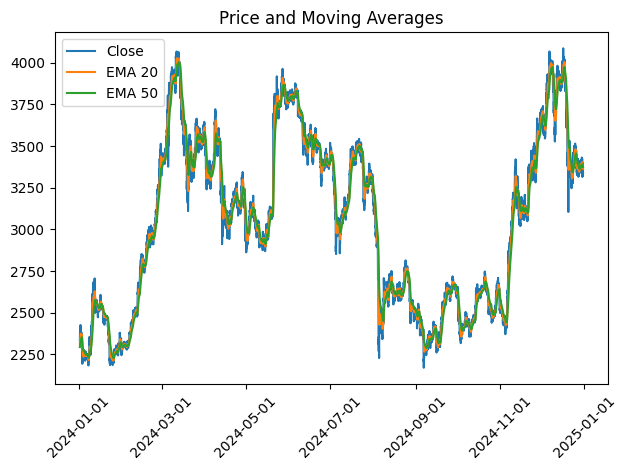

In [3]:
fig, ax = plt.subplots()
ax.plot(df_processed.index, df_processed["close"], label="Close")
ax.plot(df_processed.index, df_processed["ema_20"], label="EMA 20")
ax.plot(df_processed.index, df_processed["ema_50"], label="EMA 50")
ax.set_title("Price and Moving Averages")
ax.legend()
format_date_axis(ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

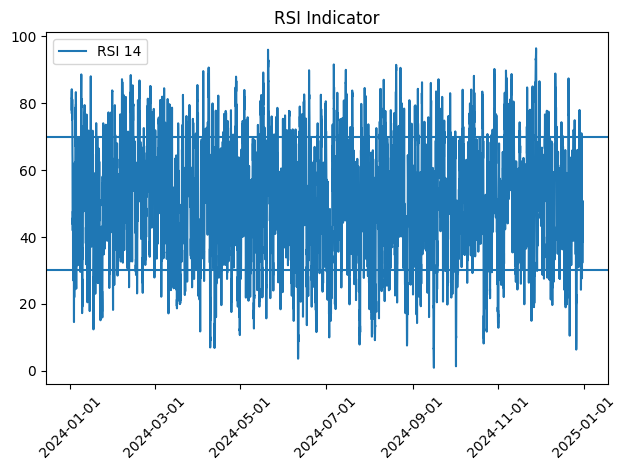

In [4]:
fig, ax = plt.subplots()
ax.plot(df_processed.index, df_processed["rsi_14"], label="RSI 14")
ax.axhline(70)
ax.axhline(30)
ax.set_title("RSI Indicator")
ax.legend()
format_date_axis(ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

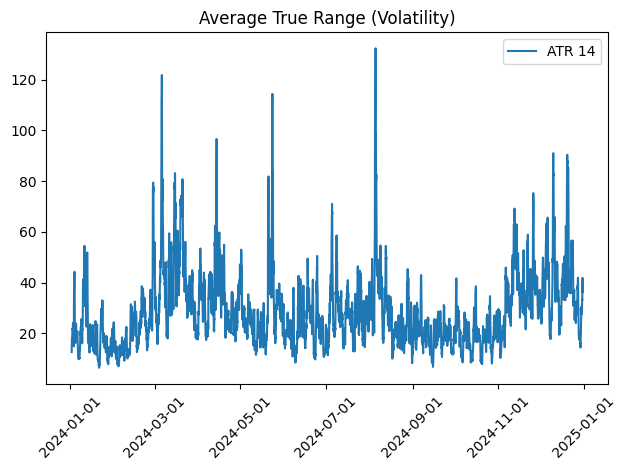

In [5]:
fig, ax = plt.subplots()
ax.plot(df_processed.index, df_processed["atr_14"], label="ATR 14")
ax.set_title("Average True Range (Volatility)")
ax.legend()
format_date_axis(ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

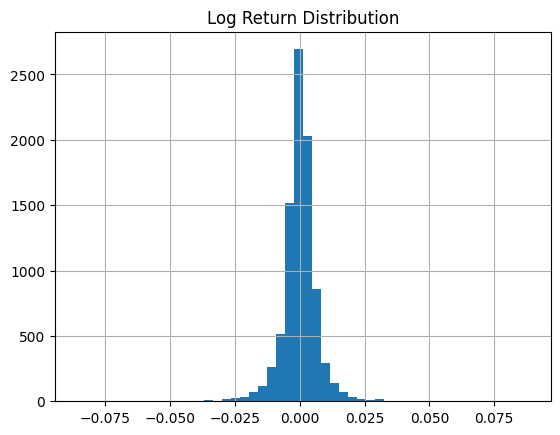

In [6]:
plt.figure()
df_processed["log_return"].hist(bins=50)
plt.title("Log Return Distribution")
plt.show()

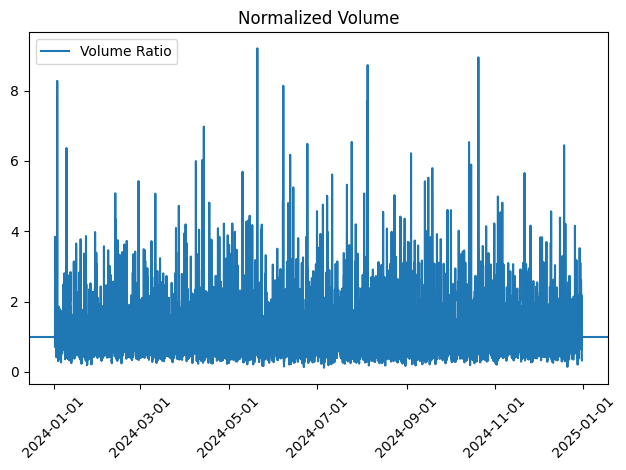

In [7]:
fig, ax = plt.subplots()
ax.plot(df_processed.index, df_processed["volume_ratio"], label="Volume Ratio")
ax.axhline(1)
ax.set_title("Normalized Volume")
ax.legend()
format_date_axis(ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Trade Performance by Exit Reason
Understanding why trades close and how exit type correlates with profitability.

---

In [8]:
def trades_by_exit_reason(trades: pd.DataFrame=df_trades) -> pd.DataFrame:
    return(
        trades
        .groupby("exit_reason")
        .agg(
            num_trades=("pnl", "count"),
            avg_pnl=("pnl", "mean"),
            win_rate=("pnl", lambda x: (x > 0).mean())
        )
        .sort_values("num_trades", ascending=False)
    )
    
print(trades_by_exit_reason())

             num_trades   avg_pnl  win_rate
exit_reason                                
TAKE-PROFIT          54  0.010278  0.870370
STOP-LOSS            18 -0.016162  0.277778


## 3. PnL Distribution
Analyzing the distribution of trade outcomes to assess risk/reward asymmetry.

---

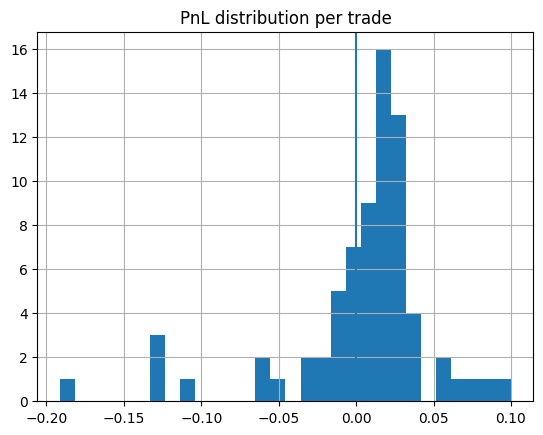

In [9]:
df_trades["pnl"].hist(bins=30)
plt.axvline(0)
plt.title("PnL distribution per trade")
plt.show()

## 4. Equity Curve vs Price
Visual confirmation that equity grows independently of price direction.

---

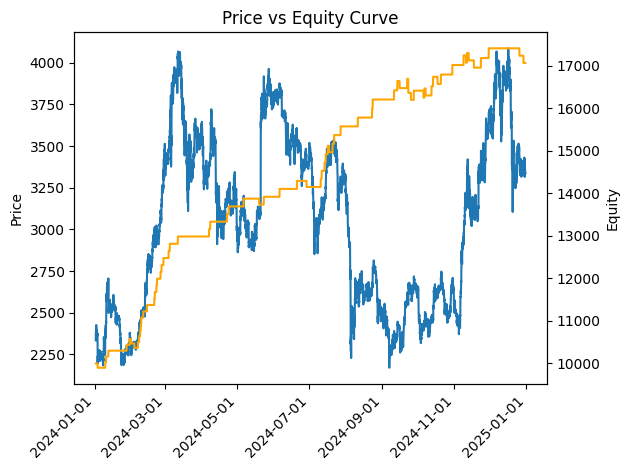

In [10]:
fig, ax1 = plt.subplots()
ax1.plot(df_backtest.index, df_backtest["close"])
ax1.set_ylabel("Price")
ax2 = ax1.twinx()
ax2.plot(df_backtest.index, df_backtest["equity_curve"], color="orange")
ax2.set_ylabel("Equity")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right') 
plt.title("Price vs Equity Curve")
plt.tight_layout()
plt.show()

## 5. RSI Entry Analysis
**Goal:** Determine if RSI entry level correlates with trade success.  
**Hypothesis:** Trades entered at RSI 50-55 (mild pullback) may have higher win rate.

---

In [11]:
# Entry RSI
df_trades["rsi_entry"] = df_trades["entry_time"].map(df_backtest["rsi_14"])

# Winning trades
df_trades["is_win"] = df_trades["pnl"] > 0

# RSI binning
bins = [40, 45, 50, 55, 60]
labels = ["40-45", "45-50", "50-55", "55-60"]
df_trades["rsi_bin"] = pd.cut(df_trades["rsi_entry"], bins=bins, labels=labels)

rsi_edge = (
    df_trades
    .groupby("rsi_bin", observed=True)
    .agg(
        num_trades=("pnl", "count"),
        win_rate=("is_win", "mean"),
        avg_pnl=("pnl", "mean"),
        avg_win=("pnl", lambda x: x[x > 0].mean()),
        avg_loss=("pnl", lambda x: x[x < 0].mean())
    )
)
rsi_edge['expectancy'] = (
    rsi_edge['win_rate'] 
    * rsi_edge['avg_win'] 
    + (1 - rsi_edge['win_rate']) 
    * rsi_edge['avg_loss']
)

print(rsi_edge)


         num_trades  win_rate   avg_pnl   avg_win  avg_loss  expectancy
rsi_bin                                                                
40-45            15  0.533333 -0.008696  0.025165 -0.047394   -0.008696
45-50            19  0.736842  0.000207  0.019577 -0.054030    0.000207
50-55            38  0.789474  0.010280  0.027120 -0.052871    0.010280


## Key Findings

**RSI Sweet Spot:** Entries at RSI 50-55 show highest win rate (78.9%) and positive expectancy (+1.03%).

**Avoid RSI below 45:** Lower win rate (53.3%) and negative expectancy (-0.87%).